In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("Online Retail.xlsx")

# Data Preprocessing

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df = df.drop(["Description"],axis=1)

In [7]:
df = df.dropna()

In [8]:
df = df.drop(["InvoiceNo"],axis=1)

In [9]:
df.isnull().sum()

StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:>

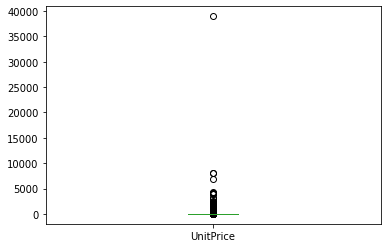

In [11]:
df["UnitPrice"].plot(kind="box")

In [16]:
df_sorted = df[df["Quantity"]!=-1].sort_values(by=["UnitPrice"], ascending=False)

In [21]:
len(df_sorted[df_sorted["UnitPrice"]>1000])

22

In [32]:
df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]

C:\Users\nehue\AppData\Local\Temp\ipykernel_11108\41533685.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]


In [54]:
import re

In [58]:
stc = df["StockCode"].unique()

stock_with_words = [stockcode for stockcode in stc if type(stockcode)!=int]
stock_with_words = [sc for sc in stock_with_words if not any(char.isdigit() for char in sc)]

In [59]:
stock_with_words

['DOT', 'M', 'POST', 'BANK CHARGES', 'PADS']

In [65]:
for word in stock_with_words:

    df = df[df["StockCode"]!=word]

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
